In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import gridspec
from scipy import stats
from sklearn import preprocessing
import os
import keras
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import random
from sklearn.model_selection import KFold

import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/l

### Functions

In [3]:
def build_data_arrays(SR, SB, gaiadata2):
    X = SR[:,3]-center_ra
    Y = SR[:,2]-center_dec

    Xb = SB[:,3]-center_ra
    Yb = SB[:,2]-center_dec
    
    Xad = gaiadata2[:, 3]-center_ra
    Yad = gaiadata2[:, 2]-center_dec

    SR = np.c_[SR[:,0],SR[:,1],X, Y, SR[:,4],SR[:,5]]
    SB = np.c_[SB[:,0],SB[:,1],Xb, Yb, SB[:,4],SB[:,5]]
    gaiadata2 = np.c_[gaiadata2[:,0],gaiadata2[:,1], Xad, Yad, gaiadata2[:,4],gaiadata2[:,5]]
    
    return SR, SB, gaiadata2

In [4]:
threshold_arr_size = 10000

In [5]:
def calc_diff(SR, SB):
    return abs(len(SR) - len(SB))

In [6]:
def find_SR_SB_pointers(pointers, increment, data_arr, start_point, end_point):
    SR = data_arr[(data_arr[:,0] > pointers[1])*(data_arr[:,0] < pointers[2])]
    SB = data_arr[(data_arr[:,0] > pointers[0])*(data_arr[:,0] < pointers[1]) + (data_arr[:,0] > pointers[2])*(data_arr[:,0] < pointers[3])]

    previous_diff = calc_diff(SR, SB)
    prev_SR, prev_SB = SR, SB
    curr_diff = previous_diff
    bottom_bool = False
    top_bool = True

    while curr_diff <= previous_diff and pointers[3] < end_point:
        previous_diff, prev_SR, prev_SB = curr_diff, SR, SB
        if bottom_bool:
            pointers[0] = max(start_point, pointers[0] - increment)
        else:
            pointers[3] = min(end_point, pointers[3] + increment)
        bottom_bool, top_bool = top_bool, bottom_bool
        SR = data_arr[(data_arr[:,0] > pointers[1])*(data_arr[:,0] < pointers[2])]
        SB = data_arr[(data_arr[:,0] > pointers[0])*(data_arr[:,0] < pointers[1]) + (data_arr[:,0] > pointers[2])*(data_arr[:,0] < pointers[3])]
        curr_diff = calc_diff(SR, SB)

    return prev_SR, prev_SB

In [7]:
def angular_distance(angle1,angle2):
    # inputs are np arrays of [ra,dec]
    deltara=np.minimum(np.minimum(np.abs(angle1[:,0]-angle2[:,0]+360),np.abs(angle1[:,0]-angle2[:,0])),\
                          np.abs(angle1[:,0]-angle2[:,0]-360))
    deltadec=np.abs(angle1[:,1]-angle2[:,1])
    return np.sqrt(deltara**2+deltadec**2)

In [8]:
#function from David's file via_machinae.py
def FilterGD1(stars):
    gd1stars=np.zeros(len(stars))
    for x in allgd1stars:
        ra=x[0]
        dec=x[1]
        pmra=x[2]
        pmdec=x[3]
    
        foundlist=angular_distance(np.dstack((stars[:,3],stars[:,2]))[0],np.array([[ra,dec]]))
        foundlist=np.sqrt(foundlist**2+(stars[:,0]-pmdec)**2+(stars[:,1]-pmra)**2)   
        foundlist=foundlist<.0001
        if len(np.argwhere(foundlist))>1:
            print(foundlist)
        if len(np.argwhere(foundlist))==1:
            gd1stars+=foundlist
    gd1stars=gd1stars.astype('bool')
    return gd1stars,stars[gd1stars]

In [9]:
def make_fractional_background(all_data, fraction):
    num = fraction*100
    frac_background = []
    for i in range(len(all_data)):
        if all_data[i][6]:
            frac_background.append(all_data[i])
        else:
            if random.randint(0, 100) < num:
                frac_background.append(all_data[i])
    frac_background = np.array(frac_background)
    frac_background = frac_background[:, :6]
    return frac_background

In [10]:
def split(data, num_splits):
    res = []
    curr = 0
    diff = len(data)//num_splits
    while curr < num_splits:
        res.append(data[curr*diff:(curr+1)*diff])
        curr += 1
    return res

### Loading data and preprocessing

In [11]:
datafile = '/data0/users/bpnachman/Gaia/gaiascan_l101.2_b58.4_ra212.7_dec55.2.npy'
gaiadata=np.load(datafile,allow_pickle=True)
gaiadata2 = np.array(gaiadata[:,[9,8,6,7,4,5]]).astype('float32') 
#pm_lat, pm_lon_coslat, lon, lat, color, mag
allgd1stars = np.load('gd1_stars.npy')
is_stream_arr, gaiadata3 = FilterGD1(gaiadata)

new_gaiadata = []
for i in range(len(gaiadata)):
    temp = np.append(gaiadata[i], is_stream_arr[i])
    new_gaiadata.append(temp)

In [12]:
gaiadata = new_gaiadata
gaiadata = np.array(gaiadata)

In [13]:
#switch 0 and 1
gaiadata2 = np.array(gaiadata[:,[8,9,6,7,4,5,10]]).astype('float32') 
gaiadata3 = np.array(gaiadata3[:,[8,9,6,7,4,5]]).astype('float32') 

In [14]:
gaiadata2 = gaiadata2[(np.abs(gaiadata2[:,0]) > 2) + (np.abs(gaiadata2[:,1]) > 2)] 
gaiadata2 = gaiadata2[(gaiadata2[:,4]>0.5) * (gaiadata2[:,4]<1)]

gaiadata3 = gaiadata3[(np.abs(gaiadata3[:,0]) > 2) + (np.abs(gaiadata3[:,1]) > 2)] 
gaiadata3 = gaiadata3[(gaiadata3[:,4]>0.5) * (gaiadata3[:,4]<1)]

# k-folding

In [15]:
#next steps: k folding, start with k = 2 (sk learn maybe has a function to split data into k pieces)
#for k > 2:
#1/k should be test, 1/k should be validation (k-1 choices), average amongst the k-1 choices, k-2/k for training, 
#loop within this structure 

#validation set -> use to pick the best model, lowest validation loss

In [1]:
frac_background = make_fractional_background(gaiadata2, 0.1)


SR = frac_background[(frac_background[:,0] > -10)*(frac_background[:,0] < -8)]
SB = frac_background[(frac_background[:,0] > -11)*(frac_background[:,0] < -10)+(frac_background[:,0] > -8)*(frac_background[:,0] < -7)]
pointer1 = -10
pointer2 = -8
stream = gaiadata3

X = np.concatenate([SR,SB])
Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB))])

myscalar = preprocessing.StandardScaler()
myscalar.fit(X)
X_scaled = myscalar.transform(X)

X_scaled = X_scaled[Y<2]
Y = Y[Y<2]

NameError: name 'make_fractional_background' is not defined

In [22]:
#split data into 5 sets

#SHUFFLE
np.random.seed(27)
np.random.shuffle(X)
np.random.seed(27)
np.random.shuffle(Y)


num_splits = 5
split_X = split(X_scaled, num_splits)
split_Y = split(Y, num_splits)

outer loop
middle loop
middle loop
inner loop
inner loop
inner loop
middle loop
inner loop
inner loop
inner loop
middle loop
inner loop
inner loop
inner loop
191


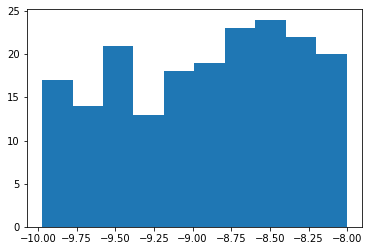

[[2.294353 ]
 [2.2461863]
 [2.2960558]
 [2.2617972]
 [2.251147 ]
 [2.2356248]
 [2.2325838]
 [2.2535985]
 [2.223183 ]
 [2.3105125]
 [2.2391434]
 [2.193378 ]
 [2.2583914]
 [2.2183893]
 [2.2598653]
 [2.1775413]
 [2.2450497]
 [2.276788 ]
 [2.2522361]
 [2.2833583]
 [2.2507672]
 [2.324834 ]
 [2.3120966]
 [2.1775584]
 [2.3185394]
 [2.3161037]
 [2.216748 ]
 [2.2271795]
 [2.3004603]
 [2.2892632]
 [2.273216 ]
 [2.2536714]
 [2.2655375]
 [2.2730267]
 [2.271375 ]
 [2.1721666]
 [2.1669059]
 [2.2266586]
 [2.253534 ]
 [2.2303717]
 [2.2146776]
 [2.2369738]
 [2.2948825]
 [2.2474825]
 [2.269968 ]
 [2.303095 ]
 [2.349235 ]
 [2.167209 ]
 [2.268846 ]
 [2.3080866]
 [2.3136   ]
 [2.2668297]
 [2.2627845]
 [2.2041335]
 [2.2696757]
 [2.2689908]
 [2.3014839]
 [2.2646832]
 [2.2509687]
 [2.3146272]
 [2.2236044]
 [2.2612696]
 [2.174374 ]
 [2.1927283]
 [2.3337102]
 [2.2077942]
 [2.3158545]
 [2.20712  ]
 [2.2552648]
 [2.1642363]
 [2.198513 ]
 [2.2725205]
 [2.2314065]
 [2.2947116]
 [2.3332055]
 [2.3048408]
 [2.3375783]

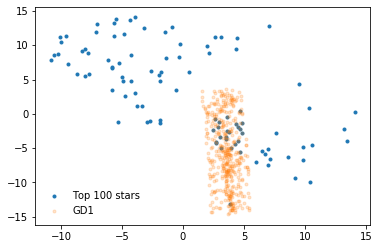

outer loop
middle loop
inner loop
inner loop
inner loop
middle loop
middle loop
inner loop
inner loop
inner loop
middle loop
inner loop
inner loop
inner loop
middle loop
inner loop
inner loop
inner loop
191


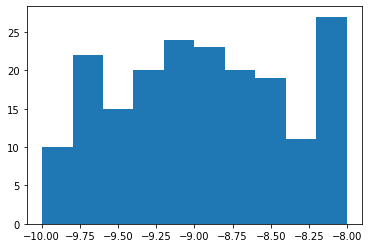

[[2.1672096]
 [2.2196343]
 [2.212207 ]
 [2.1591978]
 [2.1001432]
 [2.1545782]
 [2.1453578]
 [2.221987 ]
 [2.215849 ]
 [2.1584594]
 [2.160259 ]
 [2.2187438]
 [2.197883 ]
 [2.1123009]
 [2.0878246]
 [2.1215773]
 [2.229032 ]
 [2.2210224]
 [2.111857 ]
 [2.29853  ]
 [2.2574515]
 [2.1492484]
 [2.2118728]
 [2.179954 ]
 [2.1247668]
 [2.1461837]
 [2.119968 ]
 [2.2531083]
 [2.1344438]
 [2.2443397]
 [2.2243786]
 [2.1621847]
 [2.157465 ]
 [2.171182 ]
 [2.1613488]
 [2.1802595]
 [2.188933 ]
 [2.205504 ]
 [2.1571453]
 [2.2288737]
 [2.2075365]
 [2.1630268]
 [2.2115574]
 [2.0930233]
 [2.1058118]
 [2.1461573]
 [2.1856647]
 [2.1369586]
 [2.1356063]
 [2.203731 ]
 [2.1932025]
 [2.1395588]
 [2.1342986]
 [2.143197 ]
 [2.2309628]
 [2.1476204]
 [2.1870716]
 [2.1531818]
 [2.1782813]
 [2.2835412]
 [2.1956682]
 [2.3079407]
 [2.284345 ]
 [2.1328185]
 [2.116661 ]
 [2.163042 ]
 [2.1247244]
 [2.1022513]
 [2.1960075]
 [2.1104774]
 [2.1575499]
 [2.1854837]
 [2.2681122]
 [2.1129026]
 [2.1591682]
 [2.1382039]
 [2.2261686]

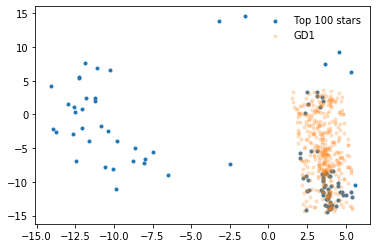

outer loop
middle loop
inner loop
inner loop
inner loop
middle loop
inner loop
inner loop
inner loop
middle loop
middle loop
inner loop
inner loop
inner loop
middle loop
inner loop
inner loop
inner loop
191


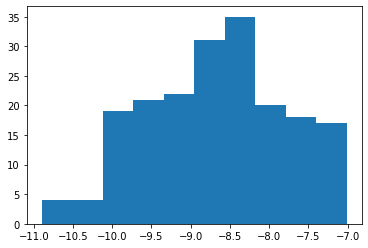

[[2.3041184]
 [2.3404284]
 [2.3365178]
 [2.3314853]
 [2.3104706]
 [2.3296409]
 [2.2786164]
 [2.2843447]
 [2.2661853]
 [2.2931573]
 [2.2611923]
 [2.3180628]
 [2.2953925]
 [2.2683778]
 [2.2893958]
 [2.268099 ]
 [2.2666452]
 [2.1698117]
 [2.2780366]
 [2.1806622]
 [2.2421255]
 [2.3045669]
 [2.206366 ]
 [2.3022468]
 [2.3123748]
 [2.2588575]
 [2.2618337]
 [2.2636714]
 [2.2756214]
 [2.3130414]
 [2.277979 ]
 [2.270616 ]
 [2.2859988]
 [2.2736583]
 [2.2744863]
 [2.2990994]
 [2.27525  ]
 [2.2930434]
 [2.2945123]
 [2.2871478]
 [2.2822063]
 [2.2777548]
 [2.3286397]
 [2.28518  ]
 [2.3014133]
 [2.3020914]
 [2.3229005]
 [2.3121996]
 [2.2787015]
 [2.2612336]
 [2.3098814]
 [2.283938 ]
 [2.2921777]
 [2.2865753]
 [2.327427 ]
 [2.2618594]
 [2.3089888]
 [2.2786748]
 [2.3027802]
 [2.3105757]
 [2.2892675]
 [2.2683694]
 [2.3244355]
 [2.310741 ]
 [2.310926 ]
 [2.3065848]
 [2.3179216]
 [2.329632 ]
 [2.275079 ]
 [2.2371876]
 [2.2806454]
 [2.3291745]
 [2.299705 ]
 [2.3296695]
 [2.276855 ]
 [2.2129245]
 [2.1180625]

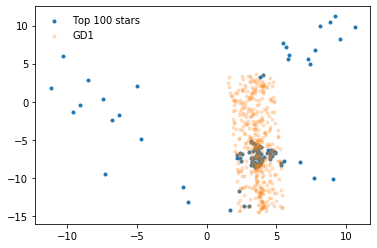

outer loop
middle loop
inner loop
inner loop
inner loop
middle loop
inner loop
inner loop
inner loop
middle loop
inner loop
inner loop
inner loop
middle loop
middle loop
inner loop
inner loop
inner loop
191


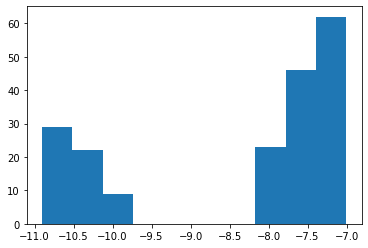

[[1.7862785]
 [1.80053  ]
 [1.8048912]
 [1.8543884]
 [1.8036816]
 [1.8063197]
 [1.8353733]
 [2.0046902]
 [1.8174098]
 [1.7818983]
 [1.8799552]
 [1.89692  ]
 [1.9234554]
 [1.844979 ]
 [1.8665383]
 [1.806702 ]
 [2.0418274]
 [1.9593142]
 [1.9819086]
 [1.8490502]
 [1.9675785]
 [1.858119 ]
 [1.869369 ]
 [1.8001592]
 [1.9000995]
 [2.2504225]
 [1.7858441]
 [1.9018435]
 [1.8501762]
 [1.8079755]
 [1.8551571]
 [1.8260663]
 [1.805717 ]
 [1.8690636]
 [1.8029318]
 [1.8224592]
 [1.7931086]
 [1.9703865]
 [1.88529  ]
 [1.8295385]
 [1.8778625]
 [1.8962761]
 [1.8261645]
 [1.8432457]
 [1.8744166]
 [1.8694038]
 [1.927617 ]
 [1.9014047]
 [1.8354928]
 [1.8710573]
 [1.8644528]
 [1.8858563]
 [1.8975043]
 [1.9970282]
 [1.9262322]
 [1.880364 ]
 [1.9075471]
 [2.0002565]
 [1.8893671]
 [1.9077258]
 [1.8515518]
 [1.9808795]
 [1.9699793]
 [2.0837514]
 [1.9620166]
 [1.8911394]
 [1.9684334]
 [1.9311185]
 [1.8240716]
 [1.8968482]
 [1.9039165]
 [1.8958563]
 [1.8830063]
 [1.9571471]
 [2.1953154]
 [2.0204003]
 [2.0161526]

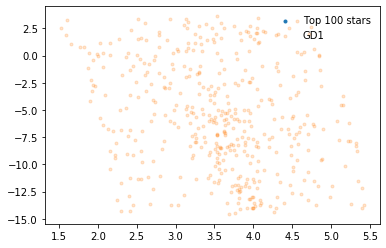

outer loop
middle loop
inner loop
inner loop
inner loop
middle loop
inner loop
inner loop
inner loop
middle loop
inner loop
inner loop
inner loop
middle loop
inner loop
inner loop
inner loop
middle loop
191


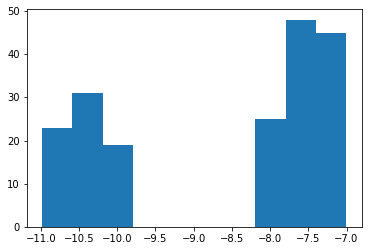

[[2.200675 ]
 [2.153952 ]
 [2.191105 ]
 [2.1896162]
 [2.1946094]
 [2.1610448]
 [2.1751468]
 [2.1629972]
 [2.1657233]
 [2.2062755]
 [2.1636677]
 [2.124578 ]
 [2.1847057]
 [2.0517955]
 [2.1912057]
 [2.089635 ]
 [2.0892167]
 [2.1766129]
 [2.0937324]
 [2.0481887]
 [2.0062323]
 [2.0087748]
 [2.1528394]
 [2.0916119]
 [2.0889525]
 [2.2269971]
 [2.0832415]
 [2.0441415]
 [2.1137357]
 [2.1882198]
 [2.1318088]
 [2.1372857]
 [2.1734488]
 [2.1608992]
 [2.160376 ]
 [2.220361 ]
 [2.2522516]
 [2.1914618]
 [2.1723568]
 [2.188557 ]
 [2.2622144]
 [2.2072835]
 [2.0644293]
 [2.1056044]
 [2.109733 ]
 [2.250464 ]
 [2.0827901]
 [2.0984714]
 [2.145514 ]
 [2.1638963]
 [2.1922584]
 [2.156038 ]
 [2.132876 ]
 [2.134353 ]
 [2.0425467]
 [2.1456873]
 [2.1621304]
 [2.1794832]
 [2.174257 ]
 [2.1788046]
 [2.03625  ]
 [2.0416176]
 [2.1465278]
 [2.1958876]
 [2.0836077]
 [2.0747964]
 [1.9921715]
 [1.9918585]
 [2.2162118]
 [2.1678915]
 [2.0126226]
 [2.1750546]
 [2.1019092]
 [2.1839721]
 [2.1942158]
 [2.1331024]
 [2.1694727]

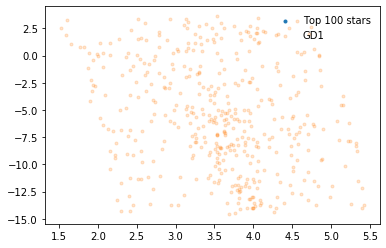

In [23]:
epochs = 20
preds_overall = []
X_test_unscaled_all = []

for test_counter in range(num_splits):
    print('outer loop')
    X_test, Y_test = split_X[test_counter], split_Y[test_counter]
    
    preds_average = []
    
    for val_counter in range(num_splits):
        print('middle loop')
        if val_counter != test_counter:
            X_val, Y_val = split_X[val_counter], split_Y[val_counter]
            
            
            X_train = []
            Y_train = []
            for train_counter in range(num_splits):
                if train_counter != test_counter and train_counter != val_counter:
                    if len(X_train) == 0:
                        X_train = split_X[train_counter]
                        Y_train = split_Y[train_counter]
                    else:
                        X_train = np.concatenate((X_train, split_X[train_counter]))
                        Y_train = np.concatenate((Y_train, split_Y[train_counter]))
                    
                    

                    
            preds_best_loop = []
            num_loops = 3
            min_loss = None
            
            
            for curr_index in range(num_loops):
                print('inner loop')
    
                model = Sequential()
                initializer =tf.keras.initializers.glorot_normal()
                model.add(Dense(64, input_dim=5, activation='relu', bias_initializer = initializer)) 
                model.add(Dropout(0.25))
                model.add(Dense(64, activation='relu', bias_initializer = initializer))
                model.add(Dropout(0.25))
                model.add(Dense(64, activation='relu', bias_initializer = initializer))
                model.add(Dropout(0.25))
                model.add(Dense(1, activation='sigmoid', bias_initializer = initializer))
                optimizer = keras.optimizers.Adam(lr=1e-4)
                model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
                history = model.fit(X_train[:,1:],Y_train, epochs=epochs, batch_size=200, 
                                    validation_data=(X_val[:,1:], Y_val), verbose = 0) 

                preds_curr = model.predict(X_test[:,1:], batch_size=int(0.1*len(X_test)))
                curr_loss = history.history['val_loss'][epochs - 1]
#                 print(curr_loss)
                
                if not min_loss or curr_loss < min_loss:
                    preds_best_loop = preds_curr
                    min_loss = curr_loss
                    
            if len(preds_average) == 0:
                preds_average = preds_best_loop
            else:
                preds_average += preds_best_loop
            
            
                
#                 loss_average += history.history['val_loss'][epochs-1]
                
#                 if len(preds_average) == 0:
#                     preds_average = preds_curr
#                 else:
#                     preds_average += preds_curr

                
#             loss_average /= num_loops
#             preds_average = np.array([elem/num_loops for elem in preds_average])
#             if loss_average < min_loss:
#                 best_val_index = val_counter
#                 min_loss = loss_average
#                 preds_best_val = preds_average
    
    preds_overall.extend(preds_average)
    print(len(preds_average))
    debug_plot(preds_average, myscalar.inverse_transform(X_test))
#     print(preds_overall)
    X_test_unscaled_all.extend(myscalar.inverse_transform(X_test))

        





In [20]:
def debug_plot(my_preds, curr_X_test):
    _,_,_=plt.hist(curr_X_test[:,0])
    plt.show()
    plt.clf()
    print(my_preds)
    print(curr_X_test)
    my_preds = np.array(my_preds)
    print(my_preds)
    stars_passing_cut = []
    preds_sorted = my_preds[np.argsort(my_preds[:,0])]
    curr_X_test = np.array(curr_X_test)
    print(curr_X_test)
    X_test_sorted = curr_X_test[np.argsort(my_preds[:,0])]
    print(X_test_sorted)
    X_test_sorted = X_test_sorted[(X_test_sorted[:,0] > pointer1) * (X_test_sorted[:,0] < pointer2)]
    print(X_test_sorted)
    stars_passing_cut = X_test_sorted[max(0, len(X_test_sorted) - 100):]
    print(stars_passing_cut)
    
    plt.scatter(stars_passing_cut[:,3],stars_passing_cut[:,2], marker = '.', label = 'Top 100 stars')
    plt.scatter(gaiadata3[:,3], gaiadata3[:,2], marker = '.', alpha = 0.2, label = 'GD1')
    plt.legend(frameon = False)
    plt.show()

    

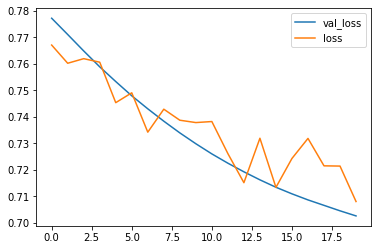

In [24]:
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.legend()

In [25]:
preds_overall = np.array(preds_overall)
stars_passing_cut = []
preds_sorted = preds_overall[np.argsort(preds_overall[:,0])]
X_test_unscaled_all = np.array(X_test_unscaled_all)
X_test_sorted = X_test_unscaled_all[np.argsort(preds_overall[:,0])]
X_test_sorted = X_test_sorted[(X_test_sorted[:,0] > pointer1) * (X_test_sorted[:,0] < pointer2)]

stars_passing_cut = X_test_sorted[len(X_test_sorted) - 100:]

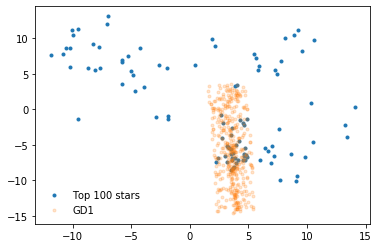

In [26]:
plt.scatter(stars_passing_cut[:,3],stars_passing_cut[:,2], marker = '.', label = 'Top 100 stars')
plt.scatter(gaiadata3[:,3], gaiadata3[:,2], marker = '.', alpha = 0.2, label = 'GD1')
plt.legend(frameon = False)
plt.show()

In [ ]:
import time

In [ ]:
start_time = time.time()

In [ ]:
#bigger batch size, lower learning rate, more epochs

Text(0.5, 0, '$\\mu_\\delta$ [$\\mu$as/year]')

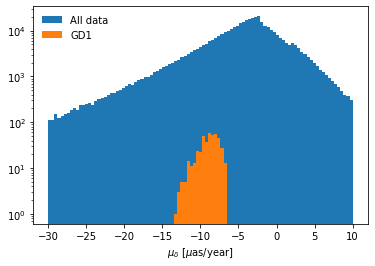

In [22]:
_,_,_=plt.hist(gaiadata2[:,0],bins=np.linspace(-30,10,100),label="All data")
_,_,_=plt.hist(gaiadata3[:,0],bins=np.linspace(-30,10,100),label="GD1")
plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")

Text(0.5, 0, '$\\mu_\\delta$ [$\\mu$as/year]')

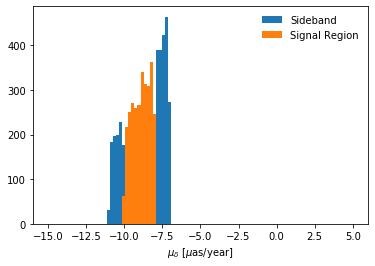

In [25]:
_,_,_=plt.hist(SB[:,0],bins=np.linspace(-15,5,100),label="Sideband")
_,_,_=plt.hist(SR[:,0],bins=np.linspace(-15,5,100),label="Signal Region")
plt.legend(frameon=False)
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")